## Creating CMIP climate anomalies

In [1]:
#Plotting and analysis libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
%matplotlib inline
import cartopy.feature as cf
import numpy as np
import xarray as xr
from scipy.stats import gaussian_kde
from tqdm.autonotebook import tqdm
import pandas as pd
import intake
import fsspec
import dask
import xmip.preprocessing as xmip
from dask_gateway import Gateway
from dask.distributed import Client
import cftime

import os
import sys
import glob
import importlib
plt.rcParams['figure.figsize'] = 12, 6

/tmp/ipykernel_1330752/3752409150.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [95]:
#Example helper function for pre processing, can also use xmip preprocessing functions

#%%
# def helper_func(ds):
#     """Rename `olevel` dim to `lev`"""
#     ds = ds.copy()
#     # a short example
#     ds = ds.squeeze()
#     if "dcpp_init_year" in ds.dims:
#         ds = ds.drop('dcpp_init_year')
#     return ds
# def helper_func(ds):
#     ds = ds.copy()
#     ds = ds.squeeze()
#     if ('longitude' in ds.dims) and ('latitude' in ds.dims):
#         ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
#     for coord in ds.coords:
#         if coord not in ['lat','lon','time']:
#             ds = ds.drop(coord)
#     return ds

In [132]:
# Define our machine's home directory
MACHDIR = os.path.expanduser("~")
HOMEREPO = '/dev/CMIP'
sys.path.append(MACHDIR + HOMEREPO + '/')

In [133]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [134]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


#### Catalogue DF lookup to see if required variables exist (not important)

In [99]:
# Get the catalog dataframe
df = col.df

# Define required variables
required_variables = {'tas', 'ps', 'mrso', 'huss'}

# Adjust table_id to include 'Amon' and 'Lmon' since 'mrso' is often under 'Lmon'
filtered_df = df[
    df['activity_id'].isin(['CMIP', 'ScenarioMIP']) &
    df['source_id'].isin(['NorESM2-MM', 'CESM2','HadGEM3-GC31-HM']) &
    df['experiment_id'].isin(['historical', 'ssp245', 'ssp585']) &
    df['variable_id'].isin(required_variables) &
    df['table_id'].isin(['Amon', 'Lmon'])   # Include 'Lmon' for 'mrso'
    #df['grid_label'] == 'gr'
]

# Group by unique combinations to ensure all variables are present
grouped = filtered_df.groupby(['source_id', 'experiment_id', 'member_id'])

valid_groups = []
for name, group in grouped:
    variables_in_group = set(group['variable_id'].unique())
    if required_variables.issubset(variables_in_group):
        valid_groups.append(group)
    else:
        print(f"Skipping group {name} because it lacks required variables.")

# Concatenate valid groups into a new dataframe
if valid_groups:
    valid_df = pd.concat(valid_groups)
else:
    raise ValueError("No datasets found with all required variables.")
valid_df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
63808,CMIP,NCAR,CESM2,historical,r10i1p1f1,Lmon,mrso,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
64084,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
64108,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
64120,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,huss,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
197874,CMIP,NCAR,CESM2,historical,r11i1p1f1,Lmon,mrso,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190514
...,...,...,...,...,...,...,...,...,...,...,...
449606,ScenarioMIP,NCC,NorESM2-MM,ssp245,r2i1p1f1,Amon,huss,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ss...,NaN,20200702
376064,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,huss,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ss...,NaN,20191108
376124,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Lmon,mrso,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ss...,NaN,20191108
376183,ScenarioMIP,NCC,NorESM2-MM,ssp585,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ss...,NaN,20191108


In [100]:
valid_df['source_id'].unique()

array(['CESM2', 'NorESM2-MM'], dtype=object)

### Catalogue Search

In [135]:
# Select the datasets for historical and future periods
query = {
    'activity_id': ['CMIP','ScenarioMIP'],
    'experiment_id': ['historical','ssp245', 'ssp585'],
    'source_id': ['E3SM-1-1','NorESM2-MM','CanESM5'],
    'variable_id': ['tas', 'ps', 'huss','areacello'],   #air temperature, surface pressure, specific humidity
    'table_id': ['Amon'],  # Monthly average data
    'member_id': ['r1i1p1f1']  # Only 1 realization for each dataset
}
cat_subset = col.search(**query)
cat_subset.df['source_id'].unique()
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
# Convert to xarray dataset
    dataset_dict = cat_subset.to_dataset_dict(
        zarr_kwargs={'consolidated': True, 'use_cftime':True},
        #preprocess=xmip.combined_preprocessing,
    )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [136]:
import xesmf as xe
ds_target = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(0, 360, 1.0), {"units": "degrees_east"}),
    }
)

ds_target = ds_target.chunk({"lat": 25, "lon": 25})
ds_target = ds_target.unify_chunks()

for name,ds in tqdm(dataset_dict.items()):
    # define the regridder object (from our source dataarray to the target)
    regridder = xe.Regridder(
        ds, ds_target, "bilinear", periodic=True)
    # apply the regridder to our source dataarray
    dataset_dict[name] = regridder(ds, keep_attrs=True).compute()

  0%|          | 0/9 [00:00<?, ?it/s]

In [225]:
varload = 'tas'
latbound = [25.375, 49.375] #
lonbound = [-124.625, -67.125] #

In [137]:
#Preprocess(?) here
for name,ds in dataset_dict.items():
    ds = xr.decode_cf(ds)
    #ds = xmip.replace_x_y_nominal_lat_lon(ds)
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
         ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
    for coord in ds.coords:
     if coord not in ['lat','lon','time']:
          ds = ds.drop(coord)  
     dataset_dict[name] = ds

In [ ]:
# Amazon lat = 4.2/25.62  , lon = 300.1/279.1
# SB lat = 34.5, lon = 240
# Harvard lat = 42.5, lon = 287.8

In [ ]:
# Amazon lat = 4.2/25.62 , lon = 300.1/-80.75
# SB lat = 34.5, lon = -120
# Harvard lat = 42.5, lon = -72.2

In [138]:
latitude = 25.62
longitude = 279.1

In [139]:
dict_tas = {}
for name, ds in tqdm(dataset_dict.items()):
    scenario = ds.attrs['experiment_id']
    model = ds.attrs['source_id']
    varname = 'tas'
    year_begin = ds['time'].values[0].year
    year_end = ds['time'].values[-1].year
    ds = ds.sel(time=slice('1850', '2100'))
    ds = ds.sel(lat=latitude, lon=longitude, method='nearest')
    tas_pick = ds[varname].values
    tas_pick_mean = tas_pick.mean()
    dict_tas['{}{}_mean_tas_{}_{}'.format(model,scenario,year_begin,year_end)] = tas_pick_mean

dict_tas

  0%|          | 0/9 [00:00<?, ?it/s]

{'NorESM2-MMssp245_mean_tas_2015_2100': 299.22763,
 'E3SM-1-1historical_mean_tas_1850_2014': 296.8272,
 'E3SM-1-1ssp245_mean_tas_2020_2024': 297.7006,
 'CanESM5ssp245_mean_tas_2015_2100': 300.1288,
 'E3SM-1-1ssp585_mean_tas_2015_2100': 300.67557,
 'NorESM2-MMssp585_mean_tas_2015_2100': 299.9343,
 'NorESM2-MMhistorical_mean_tas_1850_2014': 297.51477,
 'CanESM5ssp585_mean_tas_2015_2300': 301.13724,
 'CanESM5historical_mean_tas_1850_2014': 297.65424}

In [140]:
gmst_dict = {}
for name, ds in tqdm(dataset_dict.items()):
    ds = ds.sel(lat=latitude, lon=longitude, method='nearest')
    gmst = (ds['tas'])
    gmst_dict[name] = gmst.squeeze()

  0%|          | 0/9 [00:00<?, ?it/s]

In [141]:
#Splicing and joining the datasets
gmst_ssp_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    if 'ssp' not in name: continue # keep only SSP simulations
            
    add_hist_gmst = None
    
    # Loop through dictionary to find matching historical simulation
    for hist_name, hist_gmst in gmst_dict.items():
        model_name = name.split(".")[2] # extract model name from name of simulation
        
        # find historical simulation that matches SSP simulation (same model)
        if (model_name in hist_name) and ('historical' in hist_name):
            add_hist_gmst = hist_gmst
    
    # if we found one, slice it together with the SSP and add it to the dictionary
    if add_hist_gmst is not None:
        gmst_ssp = xr.concat([add_hist_gmst, gmst],dim='time')
        gmst_ssp_dict[name] = gmst_ssp

In [142]:
#Creating Average annual anomalies
gmst_ann = {}
for name, gmst in tqdm(gmst_ssp_dict.items()): # loop through each model
    
    # remove the climatological seasonal cycle from the signal, for visual clarity
    gmst['time'] = gmst['time'].astype('datetime64[ns]')
    gmst_climatology = gmst.groupby(gmst['time'].dt.month).mean('time')
    gmst_anomalies = gmst.groupby(gmst['time'].dt.month) - gmst_climatology
    
    # reference the GMST relative to the 1990 to 2010 pre-industrial period
    gmst_anomalies = gmst_anomalies - gmst_anomalies.isel(time=slice(1990,2010)).mean(dim='time')
    
    # calculate annual-averages, to smooth the time-series a bit
    gmst_ann_anomalies = gmst_anomalies.groupby(gmst_anomalies['time'].dt.year).mean('time')
    gmst_ann_anomalies = gmst_ann_anomalies.rename(
        r'mean surface temperature ($^{\circ}$C) (relative to 1990-2010)'
    )
    
    gmst_ann[name] = gmst_ann_anomalies.compute() 

  0%|          | 0/6 [00:00<?, ?it/s]

In [143]:
gmst_monthly = {}
for name, gmst in tqdm(gmst_ssp_dict.items()): # loop through each model
    
    # remove the climatological seasonal cycle from the signal, for visual clarity
    gmst['time'] = gmst['time'].astype('datetime64[ns]')
    gmst_climatology = gmst.groupby(gmst['time'].dt.month).mean('time')
    gmst_anomalies = gmst.groupby(gmst['time'].dt.month) - gmst_climatology
    
    # reference the GMST relative to the 1850 to 1900 pre-industrial period
    gmst_anomalies_monthly = gmst_anomalies - gmst_anomalies.isel(time=slice(1990,2010)).mean(dim='time')
    
    gmst_monthly[name] = gmst_anomalies_monthly.compute() 

  0%|          | 0/6 [00:00<?, ?it/s]

In [144]:
gmst_ssp_dict= {key.split('.')[2] + '.' + key.split('.')[3]: ds for key, ds in gmst_ssp_dict.items()}
gmst_monthly = {key.split('.')[2] + '.' + key.split('.')[3]: ds for key, ds in gmst_monthly.items()}
gmst_ann = {key.split('.')[2] + '.' + key.split('.')[3]: ds for key, ds in gmst_ann.items()}

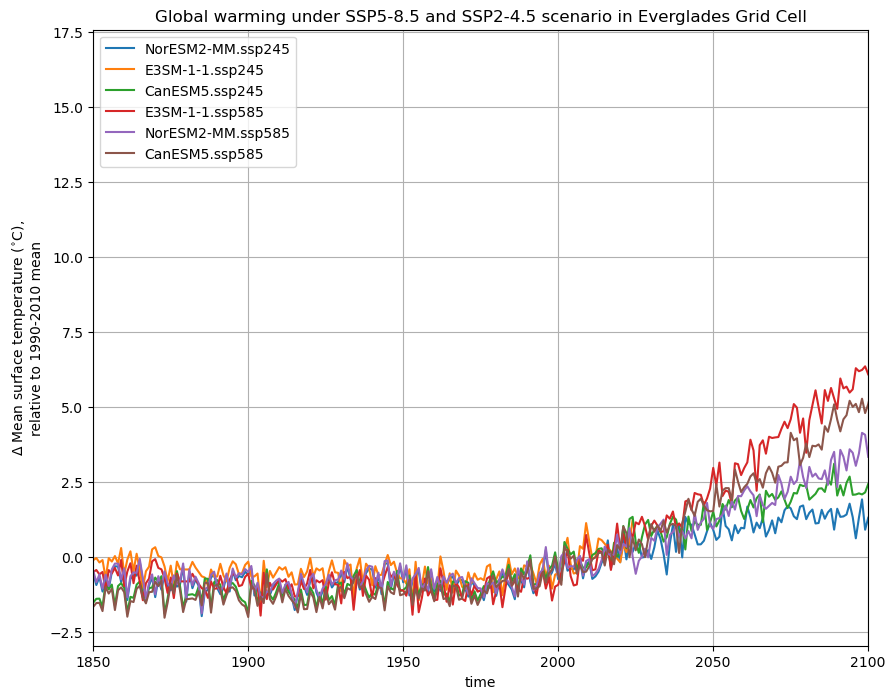

In [146]:
plt.figure(figsize=(10,8))

for name, gmst_ssp in gmst_ann.items():
    #gmst_ssp = gmst_ssp.groupby(gmst_ssp['time'].dt.year).mean('year')
    gmst_ssp.plot()
    
plt.xlabel('time')
plt.ylabel(r'${\Delta}$ Mean surface temperature ($^{\circ}$C),'
           '\n'
           'relative to 1990-2010 mean')
plt.title('Global warming under SSP5-8.5 and SSP2-4.5 scenario in Everglades Grid Cell')
plt.grid(True)
plt.legend(gmst_ssp_dict.keys(), loc='upper left')
plt.xlim([1850,2100]);
#plt.savefig('../figures/ssp585_global_warming.png',dpi=100,bbox_inches='tight')
plt.show()

In [147]:
list(gmst_monthly.keys())

['NorESM2-MM.ssp245',
 'E3SM-1-1.ssp245',
 'CanESM5.ssp245',
 'E3SM-1-1.ssp585',
 'NorESM2-MM.ssp585',
 'CanESM5.ssp585']

In [148]:
anomaly_dict = {}

for key, gmst_ssp in gmst_monthly.items():
    df = gmst_ssp.to_dataframe()
    df.rename(columns={df.columns[3]: 'tas_anomaly'}, inplace=True)
    df.drop(columns=['lat','lon','month'], inplace=True)
    anomaly_dict[key] = df

In [149]:
anomaly_dict['CanESM5.ssp245']

,tas_anomaly
time,
1850-01-16 12:00:00,-1.922578
1850-02-15 00:00:00,-3.776247
1850-03-16 12:00:00,-2.280641
1850-04-16 00:00:00,-0.416505
1850-05-16 12:00:00,-1.009523
...,...
2100-08-16 12:00:00,2.158202
2100-09-16 00:00:00,2.505858
2100-10-16 12:00:00,2.502837


In [150]:
amazon_combined_df = pd.DataFrame()

# Loop through the dictionary to build the combined DataFrame
for key, df in anomaly_dict.items():
    # Extract model and scenario from the key
    model, scenario = key.split('.')
    # Add a column for the model and scenario
    df['model'] = model
    df['scenario'] = scenario
    df.reset_index(inplace=True)  # Ensure time is a column if not already
    amazon_combined_df = pd.concat([amazon_combined_df, df], ignore_index=True)
    amazon_combined_df['time'] = pd.to_datetime(amazon_combined_df['time'])
    amazon_combined_df['year'] = amazon_combined_df['time'].dt.year
    amazon_combined_df['month'] = amazon_combined_df['time'].dt.month


print(amazon_combined_df)

                               time  tas_anomaly       model scenario  year  \
0     1850-01-16 12:00:00.000000000    -0.175607  NorESM2-MM   ssp245  1850   
1     1850-02-15 00:00:00.000000000     1.076254  NorESM2-MM   ssp245  1850   
2     1850-03-16 12:00:00.000000000    -0.362711  NorESM2-MM   ssp245  1850   
3     1850-04-16 00:00:00.000000000    -0.671640  NorESM2-MM   ssp245  1850   
4     1850-05-16 12:00:00.000000000    -0.456308  NorESM2-MM   ssp245  1850   
...                             ...          ...         ...      ...   ...   
19495 1716-01-26 12:25:26.290448384    22.083408     CanESM5   ssp585  1716   
19496 1716-02-26 00:25:26.290448384    20.316319     CanESM5   ssp585  1716   
19497 1716-03-27 12:25:26.290448384    17.458439     CanESM5   ssp585  1716   
19498 1716-04-27 00:25:26.290448384    14.135594     CanESM5   ssp585  1716   
19499 1716-05-27 12:25:26.290448384     9.268682     CanESM5   ssp585  1716   

       month  
0          1  
1          2  
2     

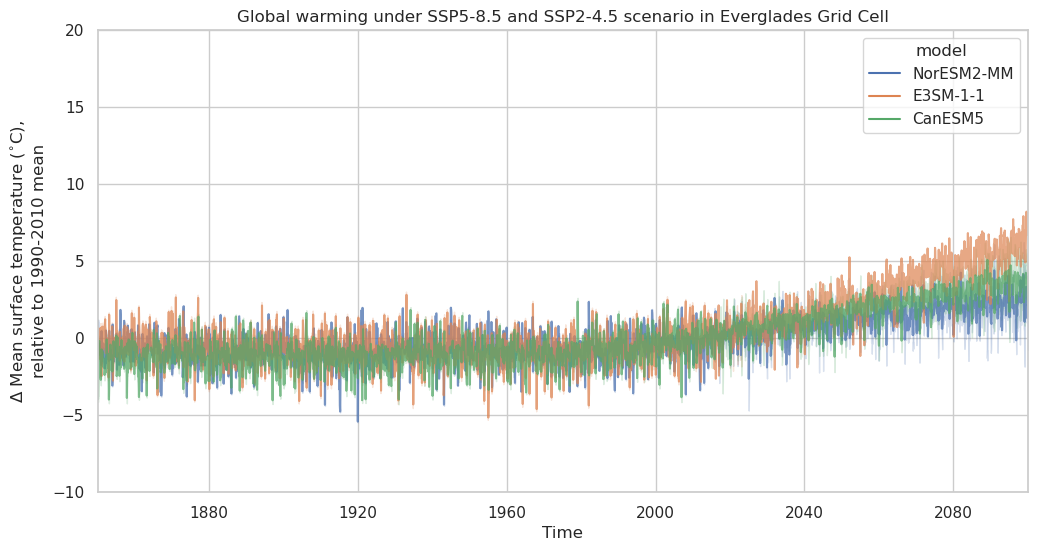

In [151]:
sns.set_theme(style="whitegrid")
p=sns.lineplot(data=amazon_combined_df, x='time', y='tas_anomaly',hue='model',alpha=0.7)

p.axis(xmin=cftime.DatetimeNoLeap(1850, 1, 1), xmax=cftime.DatetimeNoLeap(2100, 1, 1))
p.axis(ymin=-10, ymax=20)
plt.xlabel('Time')
plt.ylabel(r'${\Delta}$ Mean surface temperature ($^{\circ}$C),'
           '\n'
           'relative to 1990-2010 mean')
plt.title('Global warming under SSP5-8.5 and SSP2-4.5 scenario in Everglades Grid Cell')
plt.show()

In [152]:
amazon_combined_df.drop(columns=['time'], inplace=True)

In [153]:
amazon_combined_df

,tas_anomaly,model,scenario,year,month
0,-0.175607,NorESM2-MM,ssp245,1850,1
1,1.076254,NorESM2-MM,ssp245,1850,2
2,-0.362711,NorESM2-MM,ssp245,1850,3
3,-0.671640,NorESM2-MM,ssp245,1850,4
4,-0.456308,NorESM2-MM,ssp245,1850,5
...,...,...,...,...,...
19495,22.083408,CanESM5,ssp585,1716,1
19496,20.316319,CanESM5,ssp585,1716,2
19497,17.458439,CanESM5,ssp585,1716,3
19498,14.135594,CanESM5,ssp585,1716,4


In [154]:
amazon_combined_df.to_csv('amazon_anomaly_df.csv', index=False)

## Make Met DFs and VPD

In [97]:
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units

In [98]:
test_gldas = xr.open_mfdataset('/home/mdshadman_amin/data/GLDAS_Processed_NorthAmerica/GLDAS_CLSM025_D_A20000101_*.nc',combine='by_coords')

/home/mdshadman_amin/miniforge3/envs/xMIP/lib/python3.11/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [99]:
# Amazon lat = 4.2/25.62 , lon = -60.1/-80.75
# SB lat = 34.5, lon = -120
# Harvard lat = 42.5, lon = -72.2

In [100]:
test_gldas

<xarray.Dataset>
Dimensions:                (time: 5478, lon: 377, lat: 188)
Coordinates:
  * time                   (time) datetime64[ns] 2000-01-01 ... 2014-12-30
  * lon                    (lon) float32 -144.1 -143.9 -143.6 ... -50.38 -50.12
  * lat                    (lat) float64 24.12 24.38 24.62 ... 70.38 70.62 70.88
Data variables:
    PAR_tavg               (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>
    Qair_f_tavg            (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>
    SoilPotential_RZ_tavg  (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>
    Tair_f_tavg            (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>
    VPD_f_tavg             (time, lat, lon) float32 dask.array<chunksize=(5478, 188, 377), meta=np.ndarray>

In [ ]:
loc_dict = {'amazon': {'lat': 25.62, 'lon': -80.75},
            'sb': {'lat': 34.625, 'lon': -120},
            'harvard': {'lat': 42.5, 'lon': -72.2}}

In [ ]:
pressure = 1013.25 * units.hPa
rh_dict = {}
for loc, loc_info in loc_dict.items():
    qair = test_gldas['Qair_f_tavg'].sel(lat=loc_info['lat'], lon=loc_info['lon'], method='nearest')
    temp = test_gldas['Tair_f_tavg'].sel(lat=loc_info['lat'], lon=loc_info['lon'], method='nearest')
    rh = mpcalc.relative_humidity_from_specific_humidity(pressure, temp * units.degC, qair * (units.kg / units.kg))
    rh_dict[loc] = rh

df_dict = {}

for loc, rh in rh_dict.items():
    df_dict[loc] = rh.to_dataframe()
    df_dict[loc] = df_dict[loc].drop(columns=['lat','lon'])
    df_dict[loc] = df_dict[loc].reset_index()
    df_dict[loc] = df_dict[loc].rename(columns={df_dict[loc].columns[1]: f'{loc}_rh'})

rh_df = next(iter(df_dict.values()))
for loc, df in df_dict.items():
    if loc != list(df_dict.keys())[0]:
        rh_df = pd.merge(rh_df, df, on='time', how='outer')

rh_df = rh_df.resample('M', on='time').mean()
rh_df.reset_index(inplace=True)
rh_df['time'] = rh_df['time'].dt.strftime('%Y-%m')
#rh_df.to_csv('/home/mdshadman_amin/dev/CMIP/mets/rh_df.csv', index=False)

In [114]:
sb_met = test_gldas.sel(lat=34.625, lon=-120.5, method='nearest')

In [120]:
max(sb_met['Tair_f_tavg'].values)

24.94629

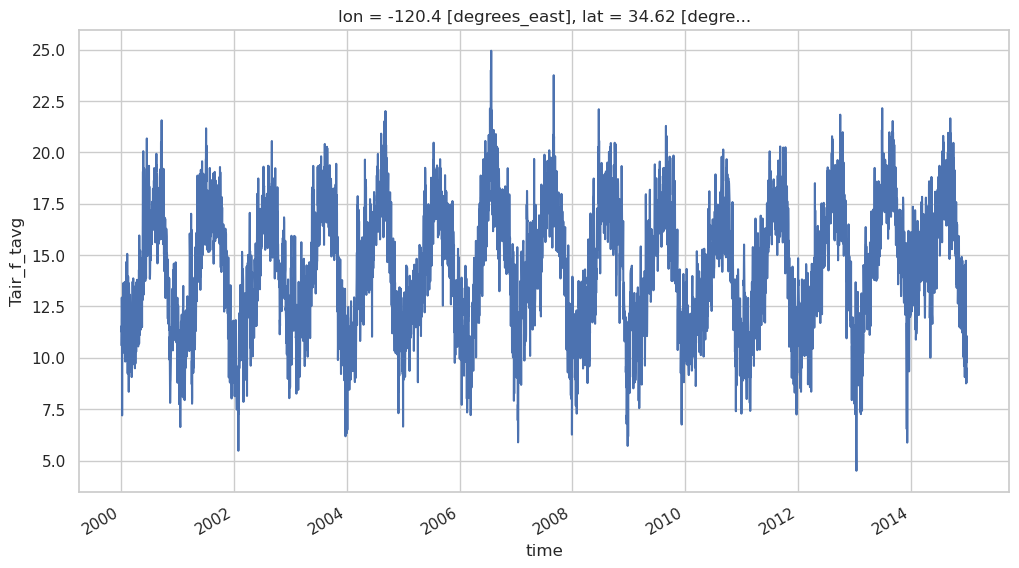

In [121]:
sb_met['Tair_f_tavg'].plot()

In [123]:
sb_met_df = sb_met.to_dataframe()

In [124]:
sb_met_df

,lon,lat,PAR_tavg,Qair_f_tavg,SoilPotential_RZ_tavg,Tair_f_tavg,VPD_f_tavg
time,,,,,,,
2000-01-01,-120.375,34.625,169.899567,0.006387,-0.615618,10.613770,2.529493
2000-01-02,-120.375,34.625,186.451767,0.006313,-0.615401,11.547455,3.466849
2000-01-03,-120.375,34.625,175.756271,0.006591,-0.618255,11.266113,2.768879
2000-01-04,-120.375,34.625,170.095627,0.007733,-0.551820,12.933716,2.485210
2000-01-05,-120.375,34.625,211.626572,0.006676,-0.500497,12.216248,3.497946
...,...,...,...,...,...,...,...
2014-12-26,-120.375,34.625,217.897583,0.004822,-0.799344,9.522980,4.143888
2014-12-27,-120.375,34.625,201.920654,0.005296,-0.805603,8.778473,2.798820
2014-12-28,-120.375,34.625,186.265045,0.004463,-0.804120,9.845062,4.980527


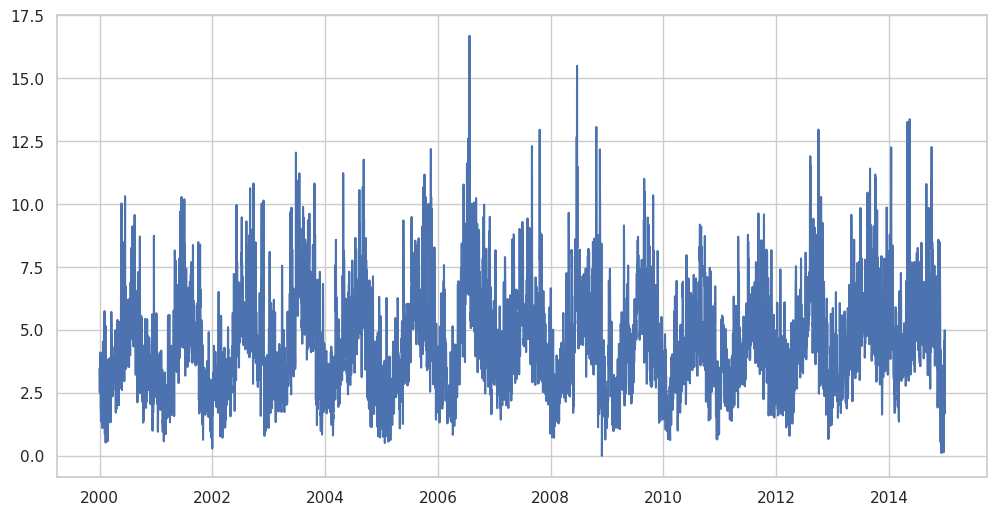

In [125]:
plt.plot(sb_met_df['VPD_f_tavg'])

In [126]:
def prep_metcsv_hotter(df):
    df = df.drop(columns=['lat','lon','PAR_tavg','Qair_f_tavg'])
    df = df.rename(columns={'Tair_f_tavg':'tair','SoilPotential_RZ_tavg':'psis','VPD_f_tavg':'D'})
    df['Ca'] = 420
    df['al'] = 10
    df = df.reset_index()
    return df

In [127]:
sb_met_df=prep_metcsv_hotter(sb_met_df)

In [154]:
sb_met_df

,time,psis,tair,D,Ca,al
0,2000-01-01,-0.615618,10.613770,2.529493,420,10
1,2000-01-02,-0.615401,11.547455,3.466849,420,10
2,2000-01-03,-0.618255,11.266113,2.768879,420,10
3,2000-01-04,-0.551820,12.933716,2.485210,420,10
4,2000-01-05,-0.500497,12.216248,3.497946,420,10
...,...,...,...,...,...,...
5473,2014-12-26,-0.799344,9.522980,4.143888,420,10
5474,2014-12-27,-0.805603,8.778473,2.798820,420,10
5475,2014-12-28,-0.804120,9.845062,4.980527,420,10
5476,2014-12-29,-0.813426,11.065674,2.363484,420,10


In [ ]:
#sb_met_df.to_csv('/home/mdshadman_amin/dev/CMIP/mets/hotter_base_sb_met_df.csv', index=False)

In [157]:
rh_df

,time,amazon_rh,sb_rh,harvard_rh
0,2000-01,0.738738,0.850474,0.738078
1,2000-02,0.733081,0.888835,0.799588
2,2000-03,0.741111,0.806068,0.830757
3,2000-04,0.719161,0.770499,0.849653
4,2000-05,0.717614,0.727818,0.884690
...,...,...,...,...
175,2014-08,0.789010,0.725994,0.804544
176,2014-09,0.829345,0.723260,0.794121
177,2014-10,0.774991,0.672454,0.855137
178,2014-11,0.782128,0.693054,0.755095


In [156]:
rh_df = pd.read_csv('/home/mdshadman_amin/dev/CMIP/mets/rh_df.csv')

In [158]:
base_met_df = pd.read_csv('/home/mdshadman_amin/dev/CMIP/mets/hotter_base_sb_met_df.csv')
base_met_df['D'] = base_met_df['D'] * 10
base_met_df['time'] = pd.to_datetime(base_met_df['time'])
base_met_df = base_met_df.resample('M', on='time').mean()
base_met_df = base_met_df.reset_index()
base_met_df['time'] = base_met_df['time'].dt.strftime('%Y-%m')
anomaly_df = pd.read_csv('/home/mdshadman_amin/dev/CMIP/mets/santabarbara_anomaly_df.csv')
anomaly_df['time'] = anomaly_df['time'] = pd.to_datetime(anomaly_df[['year', 'month']].assign(day=1),errors='coerce')
anomaly_df = anomaly_df.drop(columns=['year','month'])
anomaly_df['time'] = anomaly_df['time'].dt.strftime('%Y-%m')
anomaly_df = anomaly_df[(anomaly_df['time'] > '2085-12-30') & (anomaly_df['time'] <= '2100-12-30')]
merged_df = pd.merge(base_met_df, anomaly_df, on='time', how='outer')


In [159]:
model_list = ['CanESM5', 'E3SM-1-1', 'NorESM2-MM']
scenario_list = ['ssp245', 'ssp585']

df = anomaly_df

# Extract the relevant series from base_met_df
tair_series = base_met_df['tair'].to_list()
psis_series = base_met_df['psis']
ca_series = base_met_df['Ca']
al_series = base_met_df['al']
time_series = base_met_df['time']

In [160]:
specific_data = {}

for model in model_list:
    for scenario in scenario_list:
        filtered_data = df[(df['model'] == model) & (df['scenario'] == scenario)].copy()
        filtered_data.reset_index(drop=True, inplace=True)
        new_df = pd.DataFrame()
        new_df['model'] = filtered_data['model']
        new_df['scenario'] = filtered_data['scenario']
        new_df['time'] = time_series.values
        future_tair = []
        for i in range(len(filtered_data)):
            future_tair.append(tair_series[i] + filtered_data.iloc[i]['tas_anomaly'])
        new_df['future_tair'] = pd.Series(future_tair)
        new_df['psis'] = psis_series.values
        new_df['Ca'] = ca_series.values
        new_df['al'] = al_series.values

        # Store the new dataframe in the dictionary with a key as (model, scenario)
        specific_data[(model, scenario)] = new_df


/tmp/ipykernel_1330752/4157003805.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_df['future_tair'] = pd.Series(future_tair)


In [161]:
def met_to_vpd(air_temp, rh):
    es = (611.2 * np.exp((17.27 * air_temp) / (air_temp + 237.3)))
    vpd = (1 - (rh)) * es
    return vpd

In [162]:
location = 'sb'
# Select the appropriate RH column based on the location
rh_column = f"{location}_rh"
if rh_column in rh_df.columns:
    for (model, scenario), data in specific_data.items():
        rh_merger = pd.merge(data, rh_df[['time', rh_column]], on='time', how='left')
        rh_merger['D'] = met_to_vpd(rh_merger['future_tair'], rh_merger[rh_column])
        specific_data[(model, scenario)]['D'] = rh_merger['D']*10
else:
    print(f"Warning: RH data for {location} not found in rh_dataframe")

In [163]:
# Example of how to access data for a specific model-scenario combination
model_name = 'CanESM5'
scenario_name = 'ssp245'
example_data = specific_data.get((model_name, scenario_name), None)

# Print the modified data for example access
print(example_data)

       model scenario     time  future_tair      psis     Ca    al  \
0    CanESM5   ssp245  2000-01    13.155463 -0.425905  420.0  10.0   
1    CanESM5   ssp245  2000-02    14.226556 -0.146767  420.0  10.0   
2    CanESM5   ssp245  2000-03    13.341438 -0.076828  420.0  10.0   
3    CanESM5   ssp245  2000-04    16.336511 -0.095939  420.0  10.0   
4    CanESM5   ssp245  2000-05    18.064565 -0.135291  420.0  10.0   
..       ...      ...      ...          ...       ...    ...   ...   
175  CanESM5   ssp245  2014-08    20.105849 -0.850443  420.0  10.0   
176  CanESM5   ssp245  2014-09    19.549703 -0.851919  420.0  10.0   
177  CanESM5   ssp245  2014-10    21.721737 -0.797498  420.0  10.0   
178  CanESM5   ssp245  2014-11    17.585625 -0.703456  420.0  10.0   
179  CanESM5   ssp245  2014-12    14.040193 -0.802025  420.0  10.0   

               D  
0    2263.910875  
1    1804.569434  
2    2972.121743  
3    4266.323982  
4    5644.339413  
..           ...  
175  6453.353696  
176  62

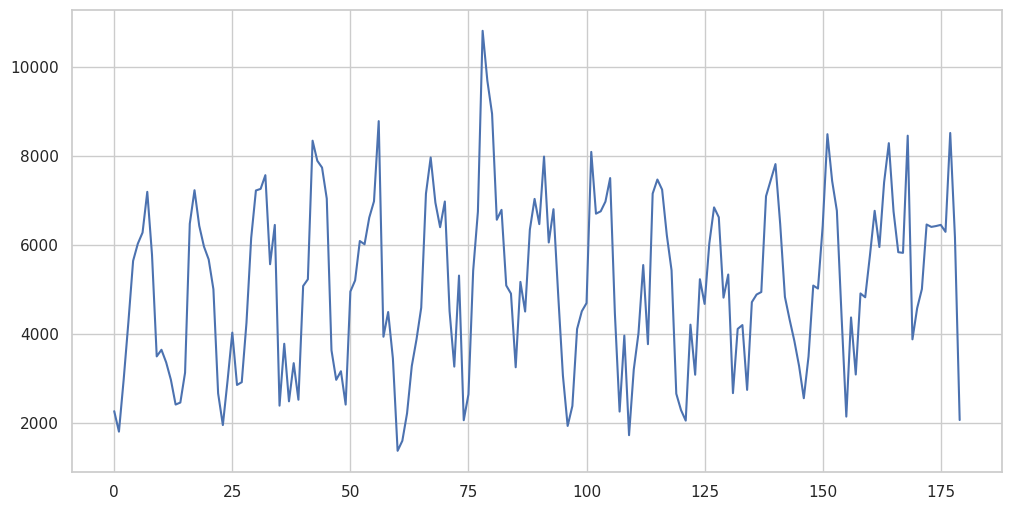

In [164]:
plt.plot(example_data['D'])

In [165]:
for (model, scenario), data in specific_data.items():
    data.to_csv(f'/home/mdshadman_amin/dev/CMIP/mets/hotter_load/hotter_{model}_{scenario}_{location}_met.csv', index=False)

## Visualization

In [166]:
loader_directory = '/home/mdshadman_amin/dev/CMIP/mets/hotter_load/'

def load_and_combine_csvs(directory):
    # Create an empty list to store dataframes
    dfs = []

    # Loop through the directory and load all CSVs
    for filename in os.listdir(directory):
        if filename.endswith('.csv') and filename.startswith('hotter_'):
            # Extract the model, scenario, and location from the filename
            parts = filename.split('_')
            model = parts[1]
            scenario = parts[2]
            location = parts[3]

            # Load the CSV file
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            if 'tair' in df.columns:
                df = df.rename(columns={'tair': 'future_tair'})

            # Ensure the time column is in datetime format
            df['time'] = pd.to_datetime(df['time'])

            # Add model, scenario, and location as new columns to the dataframe
            df['model'] = model
            df['scenario'] = scenario
            df['location'] = location

            # Append the dataframe to the list
            dfs.append(df)

    # Concatenate all dataframes into a single one
    combined_df = pd.concat(dfs)

    # Convert the combined dataframe into an xarray dataset
    combined_ds = combined_df.set_index(['time', 'model', 'scenario', 'location']).to_xarray()

    return combined_ds

In [167]:
combined_ds = load_and_combine_csvs(loader_directory)
combined_ds

<xarray.Dataset>
Dimensions:      (time: 5478, model: 4, scenario: 3, location: 3)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2014-12-30
  * model        (model) object 'CanESM5' 'E3SM-1-1' 'GLDAS' 'NorESM2-MM'
  * scenario     (scenario) object 'Observation' 'ssp245' 'ssp585'
  * location     (location) object 'amazon' 'harvard' 'sb'
Data variables:
    future_tair  (time, model, scenario, location) float64 nan nan ... nan nan
    psis         (time, model, scenario, location) float64 nan nan ... nan nan
    Ca           (time, model, scenario, location) float64 nan nan ... nan nan
    al           (time, model, scenario, location) float64 nan nan ... nan nan
    D            (time, model, scenario, location) float64 nan nan ... nan nan

In [168]:
combined_ds.loc[dict(model='GLDAS', scenario='Observation')]['D'] *= 1000

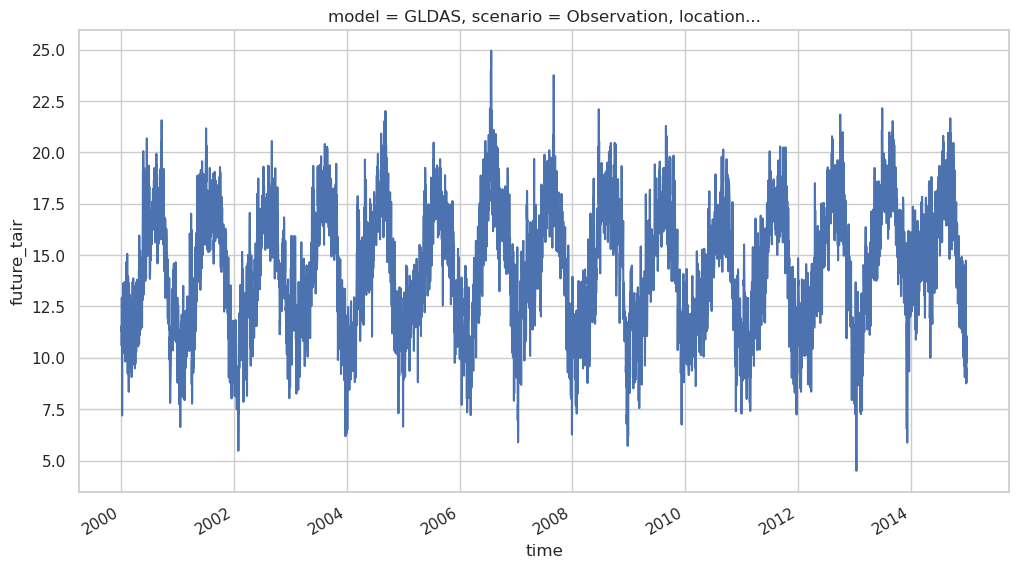

In [169]:
combined_ds.sel(scenario='Observation',model='GLDAS',location='sb')['future_tair'].plot()

In [170]:
combo = combined_ds.to_dataframe().reset_index()

In [171]:
combo

,time,model,scenario,location,future_tair,psis,Ca,al,D
0,2000-01-01,CanESM5,Observation,amazon,NaN,NaN,NaN,NaN,NaN
1,2000-01-01,CanESM5,Observation,harvard,NaN,NaN,NaN,NaN,NaN
2,2000-01-01,CanESM5,Observation,sb,NaN,NaN,NaN,NaN,NaN
3,2000-01-01,CanESM5,ssp245,amazon,22.595586,-1.058974,420.0,10.0,7167.042291
4,2000-01-01,CanESM5,ssp245,harvard,-2.730576,-0.099754,420.0,10.0,1309.320078
...,...,...,...,...,...,...,...,...,...
197203,2014-12-30,NorESM2-MM,ssp245,harvard,NaN,NaN,NaN,NaN,NaN
197204,2014-12-30,NorESM2-MM,ssp245,sb,NaN,NaN,NaN,NaN,NaN
197205,2014-12-30,NorESM2-MM,ssp585,amazon,NaN,NaN,NaN,NaN,NaN
197206,2014-12-30,NorESM2-MM,ssp585,harvard,NaN,NaN,NaN,NaN,NaN


In [172]:
combo['time'] = pd.to_datetime(combo['time'])
combo = combo.groupby([combo['time'].dt.year,combo['model'],combo['scenario'],combo['location']]).mean('time')

In [173]:
combo

future_tair      psis     Ca    al  \
time model      scenario    location                                       
2000 CanESM5    Observation amazon            NaN       NaN    NaN   NaN   
                            harvard           NaN       NaN    NaN   NaN   
                            sb                NaN       NaN    NaN   NaN   
                ssp245      amazon      27.795155 -1.513648  420.0  10.0   
                            harvard     11.304903 -0.087928  420.0  10.0   
...                                           ...       ...    ...   ...   
2014 NorESM2-MM ssp245      harvard     10.742640 -0.105045  420.0  10.0   
                            sb          15.892884 -0.697742  420.0  10.0   
                ssp585      amazon      29.950914 -0.896477  420.0  10.0   
                            harvard     15.379382 -0.105045  420.0  10.0   
                            sb          19.434988 -0.697742  420.0  10.0   

                                                D  
time model      scenario    location               
2000 CanESM5    Observation amazon            NaN  
                            harvard           NaN  
                            sb                NaN  
                ssp245      amazon    8998.924012  
                            harvard   2433.143441  
...                                           ...  
2014 NorESM2-MM ssp245      harvard   2816.353455  
                            sb        5110.634737  
                ssp585      amazon    9408.118316  
                            harvard   3853.038767  
                            sb        6307.539286  

[540 rows x 5 columns]

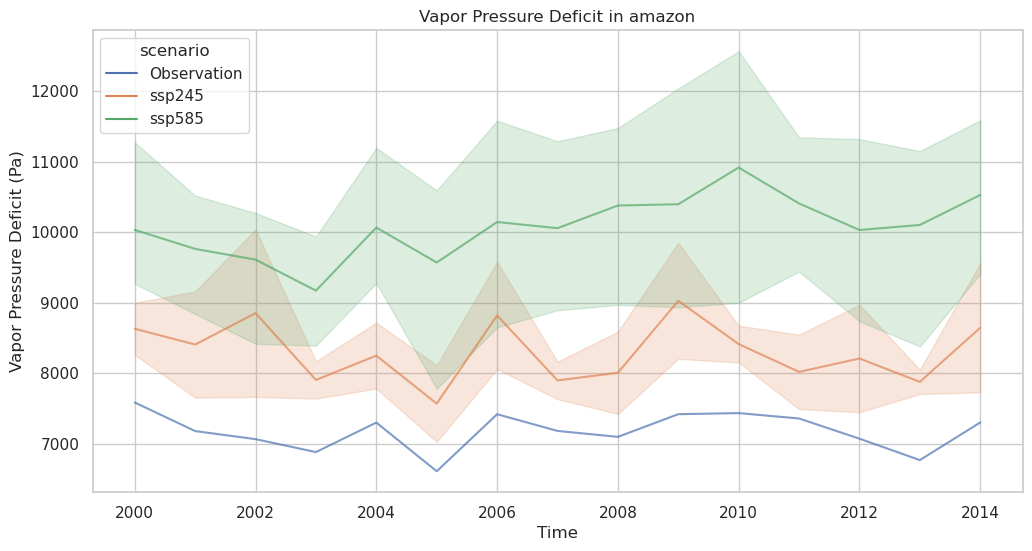

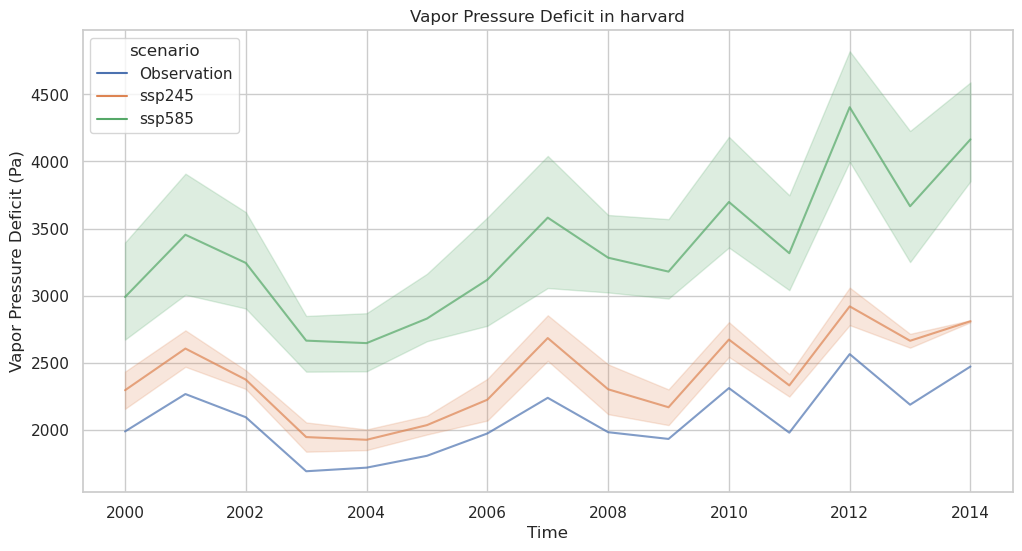

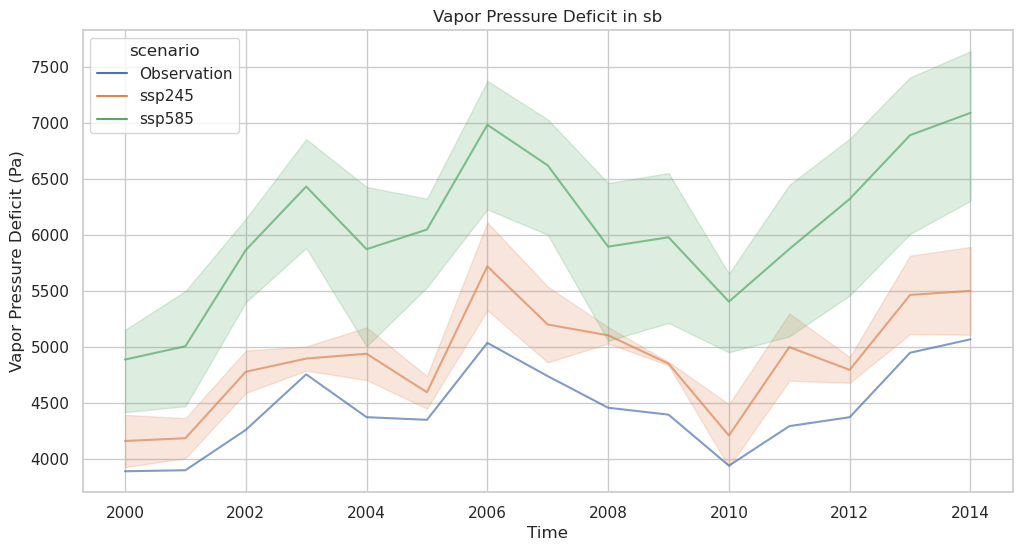

In [174]:
for location in combo.index.get_level_values('location').unique():
    filtered = combo[combo.index.get_level_values('location') == location]
    sns.set_theme(style="whitegrid")
    p=sns.lineplot(data=filtered,x='time', y='D',hue='scenario',alpha=0.7)
    plt.title(f'Vapor Pressure Deficit in {location}')
    plt.xlabel('Time')
    plt.ylabel('Vapor Pressure Deficit (Pa)')
    plt.show()

## Working with HOTTER

In [3]:
# import hotter_loader
%run hotter_loader.py

location of the primary scripts for the HOTTER model and HOTTER demo
/home/mdshadman_amin/dev/Hotter/


location for HOTTER demo outputs
/home/mdshadman_amin/data/hotter_outputs/

    # Input Parameters (defaults)
    
    States
        Lx, Tree height, (m)
        dbh, Tree diameter at breast height, (cm)
        al, Leaf area, (m2)
    Drivers
        Ca, Atmospheric CO2 concentration, (ppm), mean 1976-2005, 352.84 historical    
        D, Atmospheric vapor pressure deficit, (Pa)    
        Tair, Air temperature, (°C)
        psis, Soil water potential, (MPa)
    
    Key Parameters
        Kmax, Saturated xylem water conductivity, (mmol H2O m-1 s-1 MPa-1)
        b1, Logistic curve slope, (MPa)
        b2, P50 equivalent, (MPa)
        Vcmax0, Optimal Maximum rate of carboxylation at 25C, (umol m-2 s-1), coordinated with Jmax
        SLA, Specific leaf area, (m2 leaf per kgC)
        rG, Tree growth respiration, (fraction)
        q, Ratio of fine roots to leaves, (fraction)
    

In [4]:
# Create an input dictionary for HOTTER with default values
import pprint

input_dictionary_main = helper_scripts.default_hotter_input_dict()

pprint.pprint(input_dictionary_main)

{'Kmax': 40000,
 'LR': 18000.0,
 'Lp': 0.1,
 'SLA': 32,
 'SRA': 80,
 'Vcmax0': 80,
 'b1': 2,
 'b2': -2,
 'dbh2h1': 3.6,
 'q': 1.89,
 'rG': 0.3,
 'rho': 420,
 'sap_frac': 0.622}


In [6]:
filename_met = '/home/mdshadman_amin/dev/CMIP/mets/hotter_CanESM5_ssp585_amazon_met.csv'
df_met = pd.read_csv(filename_met)
# states
Lx = 5         # Tree height (m)
dbh = None      # Tree diameter at breast height (cm)
## Choose the list of variables to output
outputlist = ['NPP','K_frac','psi_xylem']
options_dict = input_dictionary_main.copy()

#
## Run the HOTTER model with a time vector of meteorology input
# return a data frame of the output
output_dict_time = hotter_optimization.hotter_flux_time(df_met['future_tair'], df_met['psis'], df_met['D'], df_met['Ca'], df_met['al'],
                          dbh, Lx,
                          outputlist, **options_dict)

for var in outputlist:
    output_dict_time[var] = output_dict_time[var].squeeze()

df_output = pd.DataFrame.from_dict(output_dict_time)
df_output['time'] = df_met['time']
df_output['NPP']=df_output['NPP']
df_output['Tair'] = df_met['future_tair']
df_output['psis'] = df_met['psis']
df_output['D'] = df_met['D']

pprint.pprint(df_output)

#
## Save out the output variables to folder
fname_output_here = 'hotter_CanESM5_ssp585_amazon_output.csv'
df_output.to_csv(output_directory+fname_output_here)

           NPP    K_frac  psi_xylem     time       Tair      psis           D
0    -1.764207  0.526699  -1.946551  2000-01  25.091223 -1.058974  316.158493
1    -7.964964  0.329261  -2.355765  2000-02  24.813809 -1.651113  316.041379
2   -13.981765  0.125372  -2.971255  2000-03  28.115626 -2.216846  316.063199
3   -15.035692  0.189613  -2.726263  2000-04  29.164075 -2.028765  316.130330
4   -16.453771  0.025302  -3.825632  2000-05  30.464344 -3.825632  315.982907
..         ...       ...        ...      ...        ...       ...         ...
175 -19.679081  0.608475  -1.779546  2014-08  36.283614 -0.678473  442.459347
176 -22.205286  0.644131  -1.703331  2014-09  37.962853 -0.509981  442.290502
177 -18.467353  0.614358  -1.767166  2014-10  35.856201 -0.651770  442.330766
178 -11.867195  0.550085  -1.899493  2014-11  31.047449 -0.914724  442.275140
179 -12.306470  0.395528  -2.212068  2014-12  28.414280 -1.405633  442.348095

[180 rows x 7 columns]


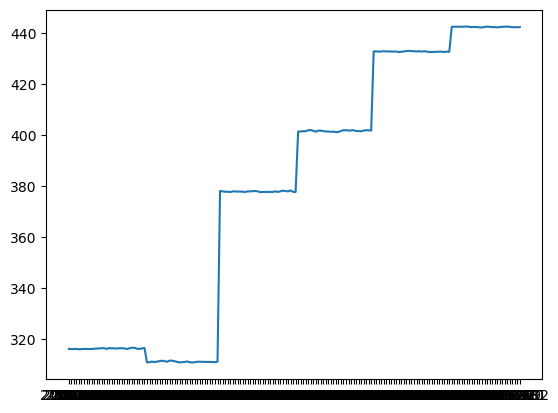

In [10]:
plt.plot(df_output['time'], df_output['D'])